# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Edoardo Tarek Holzl"
student2 = "Xavier Rubiato"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


### Plotting

In [3]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [45]:
from keras.datasets import mnist, fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

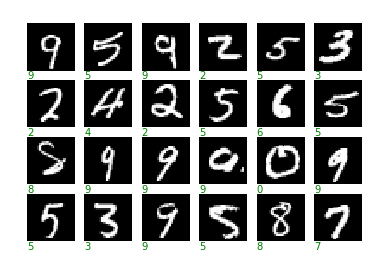

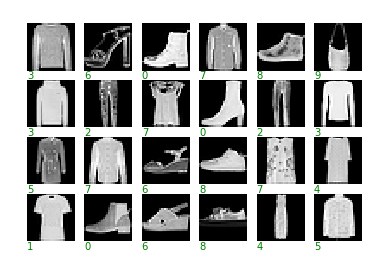

In [46]:
plot_some_samples(x_train, y_train, label_mapping=range(-1,10)); # This is to get around plotting 
plot_some_samples(x_fashion_train, y_fashion_train);


Answer to question 2: The green digits represent the class of every image

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [47]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [48]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [8]:
def create_model(opt, loss, metrics, layers=[], summary=True):
    model = Sequential()
    for l in layers:
        model.add(l)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    if summary:
        print(model.summary())
    return model

def get_misclassified_indices(yhat, y):
    indices = []
    for i, yh in enumerate(yhat):
        if yh.argmax() != y[i].argmax():
            indices.append(i)
    return indices

#### A. Run on MNIST

In [9]:
layers_1 = [Dense(input_shape=x_train[0].shape, units=y_train[0].size, activation='softmax')]
mnist_model_1 = create_model(SGD(), 'categorical_crossentropy', ['accuracy'], layers=layers_1)

mnist_hist_1 = mnist_model_1.fit(x_train, y_train, batch_size=128, validation_data=(x_test, y_test),
                       epochs=2000, callbacks=[keras.callbacks.EarlyStopping(patience=20)], verbose=0)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None


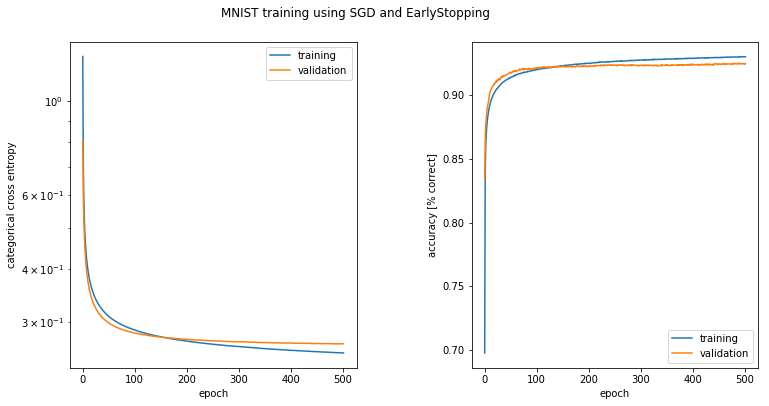

In [10]:
fig = plot_history(mnist_hist_1, 'MNIST training using SGD and EarlyStopping');
fig.set_size_inches([12, 6]);

##### Some Misclassified images

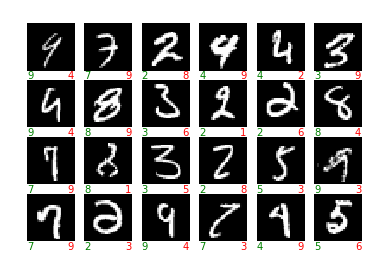

In [11]:
yhat_test = mnist_model_1.predict(x_test)
error_indices = get_misclassified_indices(yhat_test, y_test)
plot_some_samples(x_test, y_test, yhat=yhat_test, select_from=error_indices,label_mapping=range(-1,10));

#### B. Run on F-MNIST

In [12]:
layers_2 = [Dense(input_shape=x_fashion_train[0].shape, units=y_fashion_train[0].size, activation='softmax')]

fmnist_model_1 = create_model(SGD(), 'categorical_crossentropy', ['accuracy'], layers=layers_2)

fmnist_hist_1 = fmnist_model_1.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=2000,
                               validation_data=(x_fashion_test, y_fashion_test),
                               callbacks=[keras.callbacks.EarlyStopping(patience=20)], verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None


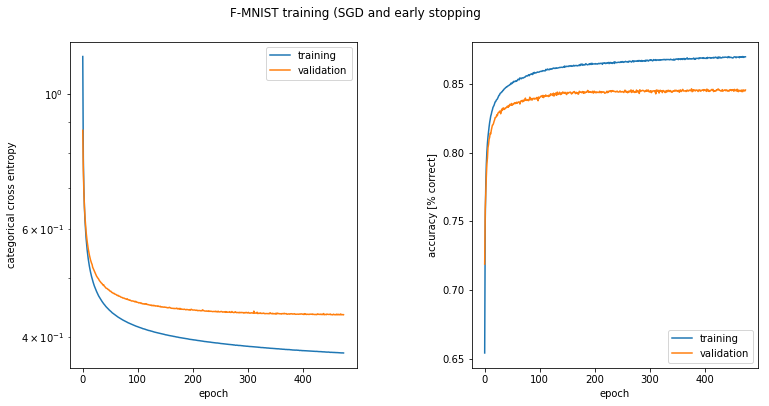

In [13]:
fig = plot_history(fmnist_hist_1, 'F-MNIST training (SGD and early stopping');
fig.set_size_inches([12,6]);

##### Some Misclassified images

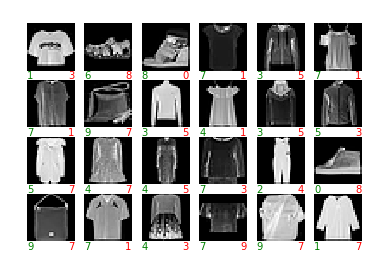

In [14]:
yhat_fashion_test = fmnist_model_1.predict(x_fashion_test)
error_indices = get_misclassified_indices(yhat_fashion_test, y_fashion_test)
plot_some_samples(x_fashion_test, y_fashion_test, yhat_fashion_test, error_indices);

Answer to question 10: The green digits represent the real class of the images, while the red one represents the most probable one according to the network (i.e. the predicted class)

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

#### 1-2. Running SGD with learning rates [0,1, 0.01, 0.001, 0.0001]

In [15]:
lr_values = [0.1, 0.01, 0.001, 0.0001]

hists = []
for lr in lr_values:
    layers = [Dense(input_shape=x_train[0].shape, units=128, activation='relu'), 
              Dense(units=y_train[0].size, activation='softmax')]
    
    mnist_model = create_model(SGD(lr=lr), loss='categorical_crossentropy',
                               metrics=['accuracy'], layers=layers)
    
    mnist_history = mnist_model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=0,
                                            validation_data=(x_test, y_test))
    hists.append((lr, mnist_history))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
______________________________________________________

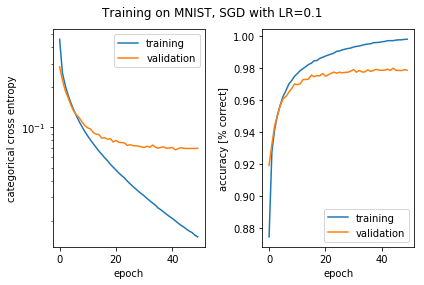

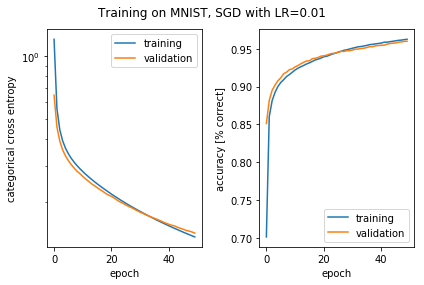

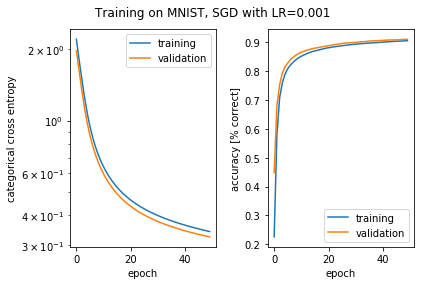

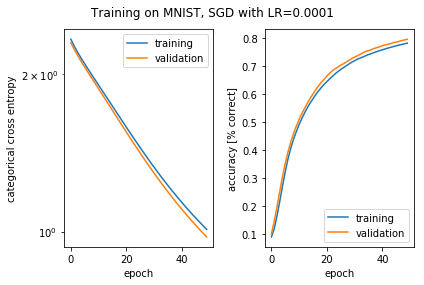

In [58]:
for lr, hist in hists:
    plot_history(hist, f'Training on MNIST, SGD with LR={lr}')

##### 3. ADAM optimizer

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


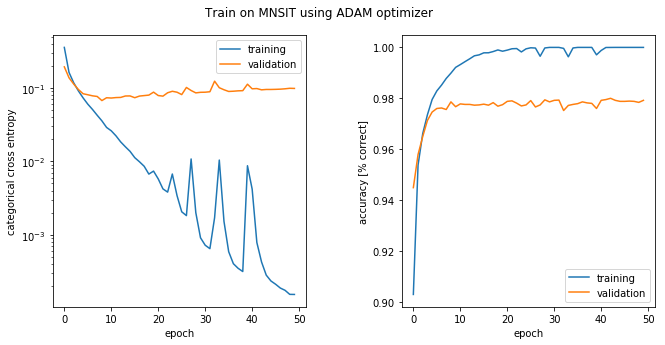

In [17]:
layers = [Dense(input_shape=x_train[0].shape, units=128, activation='relu'), 
          Dense(units=y_train[0].size, activation='softmax')]
mnist_adam = create_model(opt=Adam(), loss='categorical_crossentropy', metrics=['accuracy'], layers=layers)

adam_history = mnist_adam.fit(x_train, y_train, batch_size=128, epochs=50, verbose=0,
                                            validation_data=(x_test, y_test))
fig = plot_history(adam_history, 'Train on MNSIT using ADAM optimizer');
fig.set_size_inches([10, 5]);

##### 4. SGD vs ADAM

In [20]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [19]:
layers = [Dense(input_shape=x_train[0].shape, units=128, activation='relu'), 
          Dense(units=y_train[0].size, activation='softmax')]
mnist_sgd = create_model(opt=SGD(lr=0.02), loss='categorical_crossentropy', metrics=['accuracy'],
                         layers=layers)
sgd_history = mnist_sgd.fit(x_train, y_train, batch_size=128, epochs=50, verbose=0,
                                            validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


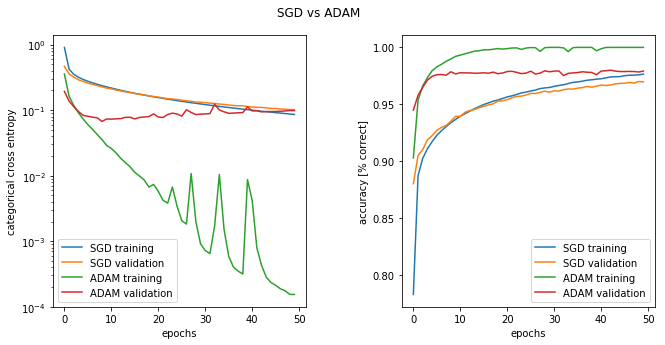

In [59]:
fig = comparison_plot(sgd_history, adam_history, 'SGD', 'ADAM', 'SGD vs ADAM');
fig.set_size_inches([10, 5]);

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) When the learning rate is very large, the alogrithm overfits on the training data, as the validation loss increases at some point instead of decrease.

B) If it is too small, the convergence will be very slow, as each update barely updates the weights.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: The overfitting starts to occur when the validation loss increases, so roughly at epoch 10

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: When overfitting occurs, the loss curves tend to diverge from each other, with one decreasing and the other increasing, as we can see on the plot above, for the ADAM optimizer, while for SGD, they seem to converge. As for the accuracy, overfitting can be detected when the train accuracy reaches almost 100%, and the validation accuracy stagnates

##### 6. ADAM in fashion mnsit

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


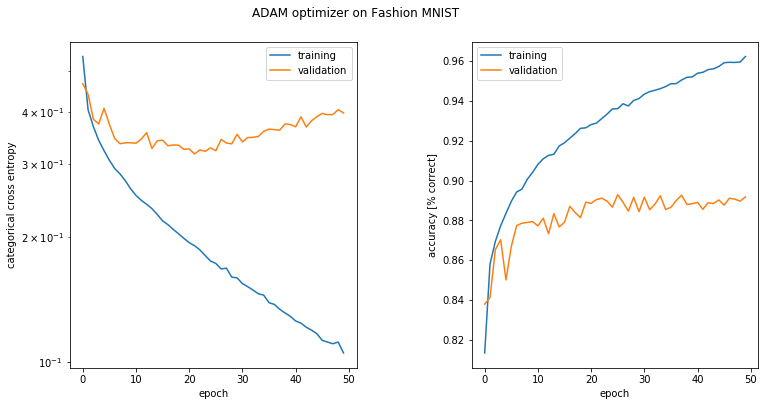

In [21]:
layers = [Dense(input_shape=x_fashion_train[0].shape, units=128, activation='relu'), 
          Dense(units=y_fashion_train[0].size, activation='softmax')]
fmnist_adam = create_model(opt=Adam(), loss='categorical_crossentropy',
                         metrics=['accuracy'], layers=layers)

adam_history_fmnist = fmnist_adam.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=50,
                                      verbose=0, validation_data=(x_fashion_test, y_fashion_test))
fig = plot_history(adam_history_fmnist, 'ADAM optimizer on Fashion MNIST')
fig.set_size_inches([12, 6]);

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

#### A. MNIST

In [22]:
hidden_neurons = [50,250, 500, 750, 1000]
histories = []
for h in hidden_neurons:
    for i in range(5):
        layers = [Dense(input_shape=x_train[0].shape, units=h, activation='relu'), 
                  Dense(y_train[0].size, activation='softmax')]
        
        model = create_model(Adam(), 'categorical_crossentropy', metrics=['accuracy'], 
                            layers=layers)
        hist = model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=0,
                                                validation_data=(x_test, y_test))
        best_val_loss = min(hist.history['val_loss'])
        best_val_acc = max(hist.history['val_acc'])
        histories.append((h, best_val_loss, best_val_acc))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_18 (Dense)             (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_20 (Dense)             (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
None
__________________________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_46 (Dense)             (None, 10)                5010      
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 750)               588750    
_________________________________________________________________
dense_48 (Dense)             (None, 10)                7510      
Total params: 596,260
Trainable params: 596,260
Non-trainable params: 0
_________________________________________________________________
None
______________________________________________________

In [23]:
from itertools import groupby
def plot_hidden_neurons(hists):
    res = []
    for h, g in groupby(hists, lambda x: x[0]):
        losses, accs = zip(*[x[1:] for x in g])
        res.append((h, np.mean(losses), np.mean(accs)))
    fig, ax1, ax2 = prepare_standardplot('Best Validation Loss/Accuracy for MNIST', 'Number of hidden layers')
    ax1.plot(hidden_neurons, [x[1] for x in res])
    ax2.plot(hidden_neurons, [x[2] for x in res])
    finalize_standardplot(fig, ax1, ax2)
    fig.set_size_inches([10, 5])

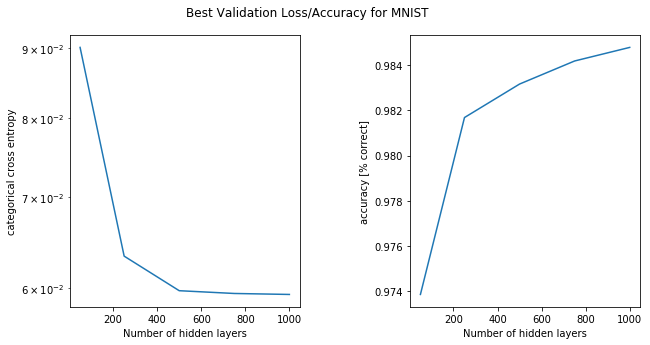

In [24]:
plot_hidden_neurons(histories)

#### B. Fashion-MNIST

In [25]:
histories_f = []
for h in hidden_neurons:
    for i in range(5):
        layers = [Dense(input_shape=x_train[0].shape, units=h, activation='relu'), 
                  Dense(y_train[0].size, activation='softmax')]
        
        model = create_model(Adam(), 'categorical_crossentropy', metrics=['accuracy'], 
                            layers=layers)
        hist = model.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=20, verbose=0,
                                                validation_data=(x_fashion_test, y_fashion_test))
        best_val_loss = min(hist.history['val_loss'])
        best_val_acc = max(hist.history['val_acc'])
        histories_f.append((h, best_val_loss, best_val_acc))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_68 (Dense)             (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_70 (Dense)             (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
None
__________________________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_96 (Dense)             (None, 10)                5010      
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 750)               588750    
_________________________________________________________________
dense_98 (Dense)             (None, 10)                7510      
Total params: 596,260
Trainable params: 596,260
Non-trainable params: 0
_________________________________________________________________
None
______________________________________________________

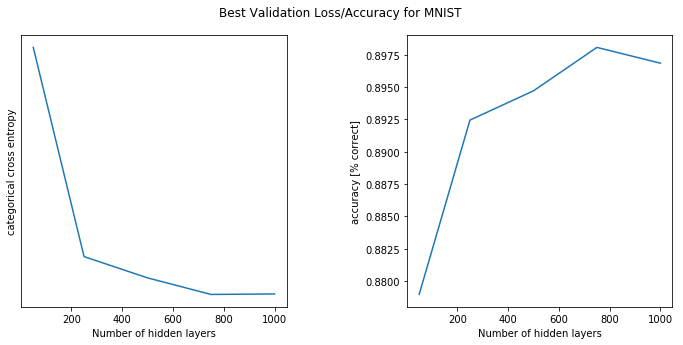

In [26]:
plot_hidden_neurons(histories_f)

Answer to question 2: The general approximation theorem states that a single hidden layer feed-forward network can _uniformly approximate any arbitrary continous mapping with any precision_ under the conditions that the activation functions are bounded and have unequal limits at infinities. However, to approximate **_any_** function, the hidden layer width can be very large, making it very long to train the network. As we can see (for MNIST), increasing the number of hidden neurons gives a better performance, reducing the validation loss and increasing the accuracy to almost 100%. However, for the Fashion MNIST, we can see a decrease in validation accuracy for 1000 hidden neurons, which can suggest overfitting on the training data, and is not in accordance with the Universal approximation theorem. This deviation can be due to the fact that the function we are trying to estimate does not fulfill the necessary conditions of the theorem

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

#### A. Only adding layers (Naive)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_20 (Dense)             (None, 50)                6450      
_________________________________________________________________
dense_21 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_22 (Dense)             (None, 10)                510       
Total params: 109,990
Trainable params: 109,990
Non-trainable params: 0
_________________________________________________________________
None


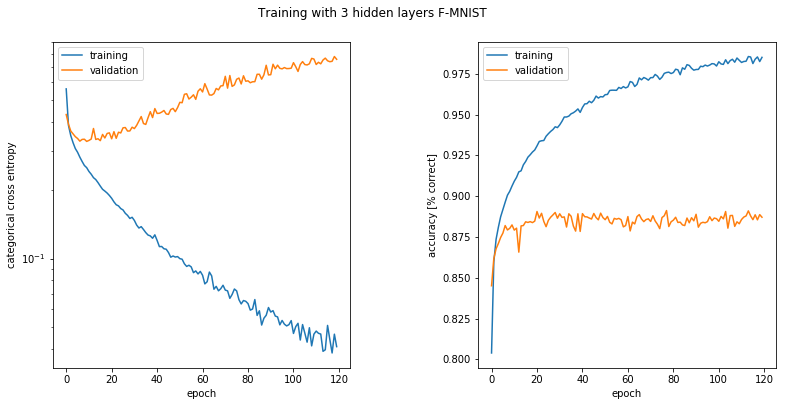

In [23]:
layers_naive = [Dense(input_shape=x_fashion_train[0].shape, units=128, activation='relu'),
                Dense(units=50, activation='relu'), Dense(units=50, activation='relu'),
                Dense(units=y_fashion_train[0].size, activation='softmax')]

model_naive = create_model(Adam(), 'categorical_crossentropy', metrics=['accuracy'],
                    layers=layers_naive)
hist_naive = model_naive.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=120, verbose=0,
                                            validation_data=(x_fashion_test, y_fashion_test))
fig = plot_history(hist_naive, 'Training with 3 hidden layers F-MNIST');
fig.set_size_inches([12,6])

#### B. Adding Dropout Layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
__________

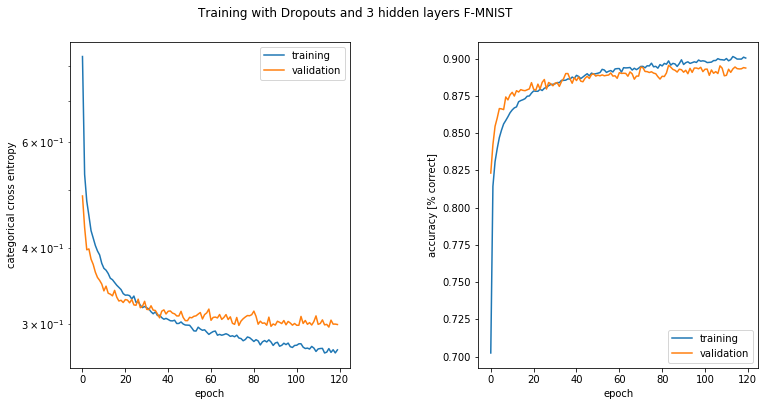

In [16]:
ratio = 0.2
layers_drp = [Dropout(ratio, input_shape=x_fashion_train[0].shape),
              Dense(128, activation='relu'),
              Dropout(ratio), 
              Dense(50, activation='relu'),
              Dropout(ratio),
              Dense(50, activation='relu'),
              Dropout(ratio),
              Dense(y_fashion_train[0].size, activation='softmax')]

model_drp = create_model(Adam(), 'categorical_crossentropy', ['accuracy'], layers=layers_drp)
hist_drp = model_drp.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=120, verbose=0,
                                            validation_data=(x_fashion_test, y_fashion_test))
fig = plot_history(hist_drp, 'Training with Dropouts and 3 hidden layers F-MNIST');
fig.set_size_inches([12,6]);

#### C. Adding BatchNormalization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_5 (Dropout)          (None, 784)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 784)               3136      
_________________________________________________________________
dense_11 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_12 (Dense)             (None, 50)                6450      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
__________

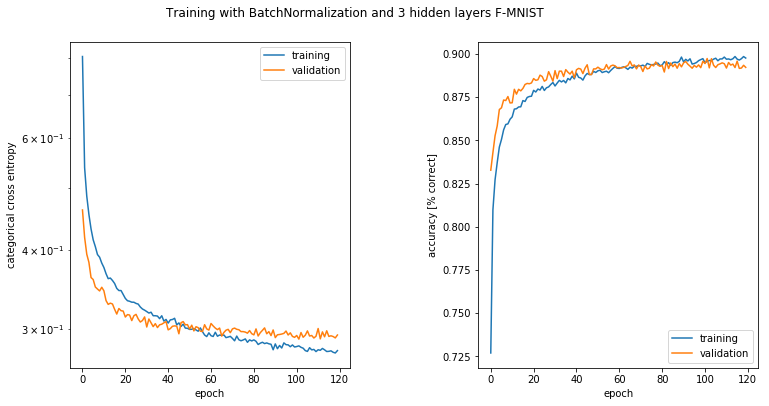

In [17]:
from keras.layers import BatchNormalization
ratio = 0.2

layers_b = [Dropout(ratio, input_shape=x_fashion_train[0].shape), BatchNormalization(),
            Dense(128, activation='relu'),
            Dropout(ratio), BatchNormalization(),
            Dense(50, activation='relu'),
            Dropout(ratio), BatchNormalization(),
            Dense(50, activation='relu'),
            Dropout(ratio), BatchNormalization(),
            Dense(y_fashion_train[0].size, activation='softmax')]

model_b = create_model(Adam(), 'categorical_crossentropy', ['accuracy'], layers=layers_b)
hist_b = model_b.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=120, verbose=0,
                                            validation_data=(x_fashion_test, y_fashion_test))
fig = plot_history(hist_b, 'Training with BatchNormalization and 3 hidden layers F-MNIST');
fig.set_size_inches([12,6]);

#### D. Adding Regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_40 (Dropout)         (None, 784)               0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 784)               3136      
_________________________________________________________________
dense_45 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_41 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 128)               512       
_________________________________________________________________
dense_46 (Dense)             (None, 50)                6450      
_________________________________________________________________
dropout_42 (Dropout)         (None, 50)                0         
__________

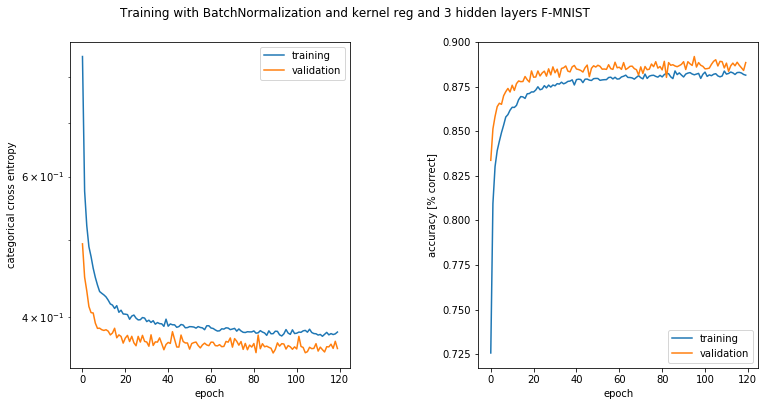

In [49]:
from keras import regularizers
ratio = 0.2
reg = 1e-4
layers = [Dropout(ratio, input_shape=x_fashion_train[0].shape), BatchNormalization(),
          Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg)),
          Dropout(ratio), BatchNormalization(),
          Dense(50, activation='relu', kernel_regularizer=regularizers.l2(reg)),
          Dropout(ratio), BatchNormalization(),
          Dense(50, activation='relu', kernel_regularizer=regularizers.l2(reg)),
          Dropout(ratio), BatchNormalization(),
          Dense(y_fashion_train[0].size, activation='softmax')]


model_reg = create_model(Adam(), 'categorical_crossentropy', ['accuracy'], layers=layers)
hist_reg = model_reg.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=120, verbose=0,
                                            validation_data=(x_fashion_test, y_fashion_test))
fig = plot_history(hist_reg, 'Training with BatchNormalization and kernel reg and 3 hidden layers F-MNIST');
fig.set_size_inches([12,6]);


#### E. Comparing best model to naive model

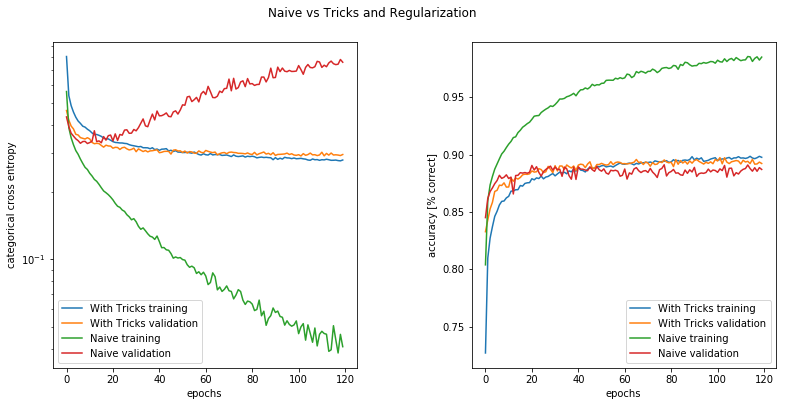

In [34]:
fig = comparison_plot(hist_b, hist_naive, 'With Tricks', 'Naive', 'Naive vs Tricks and Regularization' )
fig.set_size_inches([12,6])

In [32]:
print(f"Naive Implementation: min_val_loss={min(hist_naive.history['val_loss'])}, max_val_acc={max(hist_naive.history['val_acc'])}")
print(f"With tricks: min_val_loss={min(hist_b.history['val_loss'])}, max_val_acc={max(hist_b.history['val_acc'])}")

Naive Implementation: min_val_loss=0.3291096877336502, max_val_acc=0.8912
With tricks: min_val_loss=0.28963644247055054, max_val_acc=0.8974


Answer to question 2 (comments): The difference between the naive implementation and the one with batchnorm and dropout is quite significant (visually). We can see that when adding those layers, the network is prevented from overfitting on the training data, and seems to be able to reach better accuracy if trained long enough. Also compared to the single hidden layer network, the performance seems better

#### F. Running best model on MNIST

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_17 (Dropout)         (None, 784)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 784)               3136      
_________________________________________________________________
dense_27 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 128)               512       
_________________________________________________________________
dense_28 (Dense)             (None, 50)                6450      
_________________________________________________________________
dropout_19 (Dropout)         (None, 50)                0         
__________

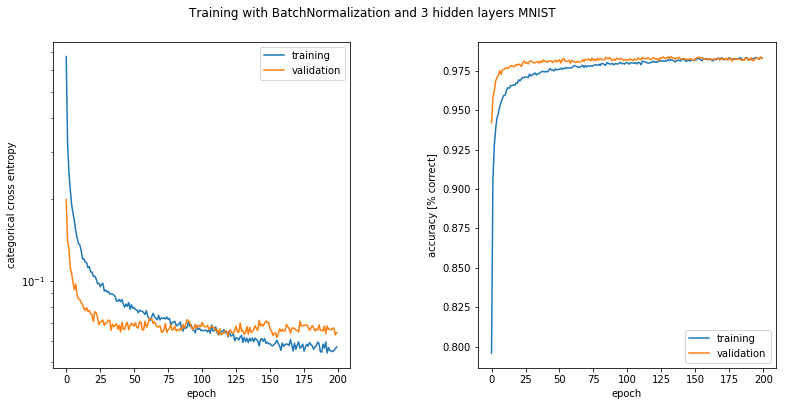

In [35]:
ratio = 0.2

layers_b_mnist = [Dropout(ratio, input_shape=x_train[0].shape), BatchNormalization(),
                  Dense(128, activation='relu'),
                  Dropout(ratio), BatchNormalization(),
                  Dense(50, activation='relu'),
                  Dropout(ratio), BatchNormalization(),
                  Dense(50, activation='relu'),
                  Dropout(ratio), BatchNormalization(),
                  Dense(y_train[0].size, activation='softmax')]

model_b_mnist = create_model(Adam(), 'categorical_crossentropy', ['accuracy'], layers=layers_b_mnist)
hist_b_mnist = model_b_mnist.fit(x_train, y_train, batch_size=128, epochs=200, verbose=0,
                                            validation_data=(x_test, y_test))
fig = plot_history(hist_b_mnist, 'Training with BatchNormalization and 3 hidden layers MNIST');
fig.set_size_inches([12,6]);

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [36]:
from keras import backend as K
def reshape_data(train, test, img_rows, img_cols):
    if K.image_data_format() == 'channels_first':
        train = train.reshape(train.shape[0], 1, img_rows, img_cols)
        test = test.reshape(test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        train = train.reshape(train.shape[0], img_rows, img_cols, 1)
        test = test.reshape(test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
    return train, test, input_shape

#### A. MNIST CNN

In [37]:
x_train, x_test, input_shape = reshape_data(x_train, x_test, 28, 28)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
__________

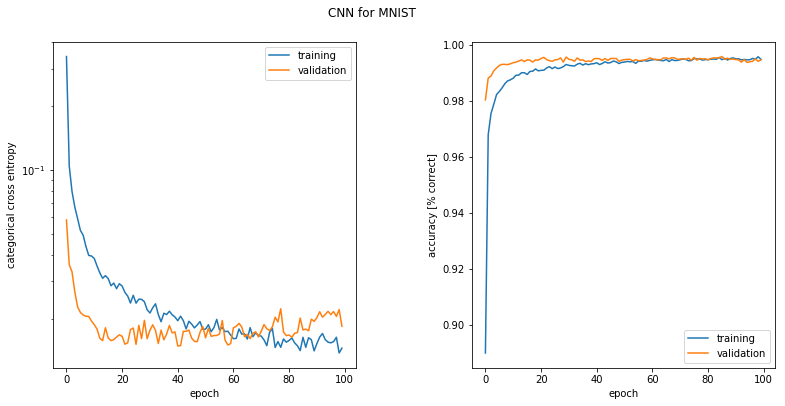

In [39]:
layers = [Conv2D(32, kernel_size=5, activation='relu', input_shape=input_shape),
          MaxPooling2D(pool_size=(2,2)),
          Dropout(0.4),
          Conv2D(64, kernel_size=5, activation='relu'), 
          MaxPooling2D(pool_size=(2,2)),
          Dropout(0.4),
          Flatten(),
          Dense(128, activation='relu'),
          Dropout(0.4),
          Dense(y_train[0].size, activation='softmax')]

model_mnist_cnn = create_model(opt=Adam(), loss='categorical_crossentropy', metrics=['accuracy'], layers=layers)
hist_mnist_cnn = model_mnist_cnn.fit(x_train, y_train, batch_size=128, epochs=100, verbose=0, validation_data=(x_test, y_test))

fig = plot_history(hist_mnist_cnn, 'CNN for MNIST');
fig.set_size_inches([12,6]);

#### B. Fashion MNIST CNN

In [53]:
x_fashion_train, x_fashion_test, input_shape = reshape_data(x_fashion_train, x_fashion_test, 28, 28)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
__________

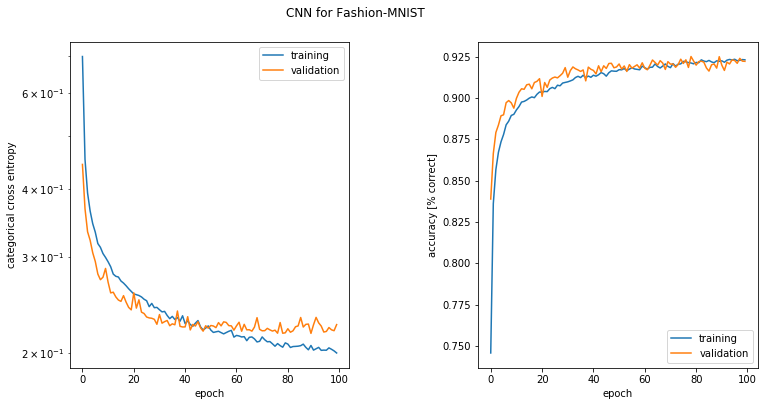

In [41]:
layers = [Conv2D(32, kernel_size=5, activation='relu', input_shape=input_shape),
          MaxPooling2D(pool_size=(2,2)),
          Dropout(0.4),
          Conv2D(64, kernel_size=5, activation='relu'), 
          MaxPooling2D(pool_size=(2,2)),
          Dropout(0.4),
          Flatten(),
          Dense(128, activation='relu'),
          Dropout(0.4),
          Dense(y_train[0].size, activation='softmax')]

model_fmnist_cnn = create_model(opt=Adam(), loss='categorical_crossentropy', metrics=['accuracy'], layers=layers)
hist_fmnist_cnn = model_fmnist_cnn.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=100, verbose=0, validation_data=(x_fashion_test, y_fashion_test))
fig = plot_history(hist_fmnist_cnn, 'CNN for Fashion-MNIST');
fig.set_size_inches([12,6]);

#### C. CNN vs Feed-Forward

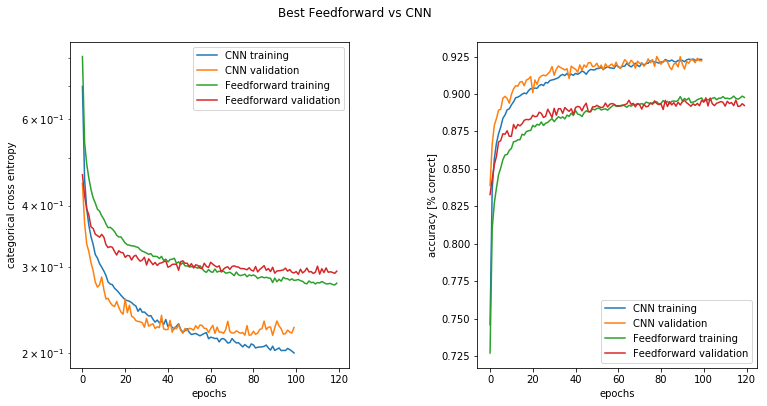

In [51]:
fig = comparison_plot(hist_fmnist_cnn, hist_b, "CNN", "Feedforward", "Best Feedforward vs CNN")
fig.set_size_inches([12,6])

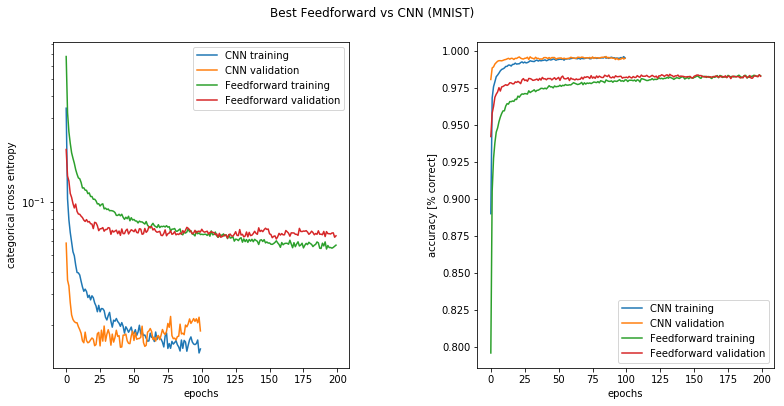

In [56]:
fig = comparison_plot(hist_mnist_cnn, hist_b_mnist, "CNN", "Feedforward", "Best Feedforward vs CNN (MNIST)")
fig.set_size_inches([12,6])

Answer to question 3: The CNN performs quite better than the previous best performing network, as it converges faster and produces much better quality results

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
__________

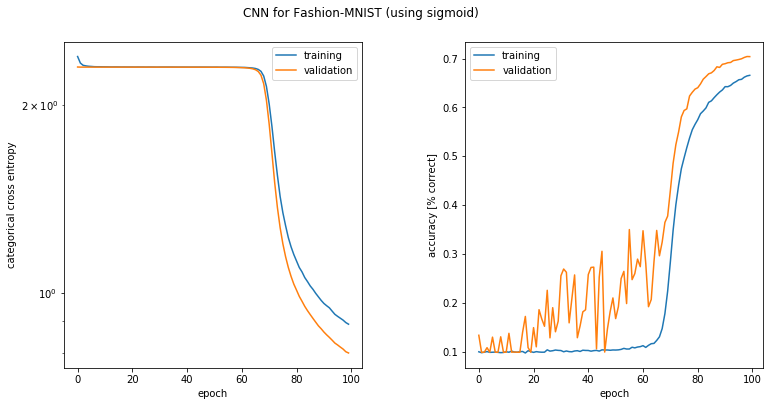

In [42]:
layers = [Conv2D(32, kernel_size=5, activation='sigmoid', input_shape=input_shape),
          MaxPooling2D(pool_size=(2,2)),
          Dropout(0.4),
          Conv2D(64, kernel_size=5, activation='sigmoid'), 
          MaxPooling2D(pool_size=(2,2)),
          Dropout(0.4),
          Flatten(),
          Dense(128, activation='sigmoid'),
          Dropout(0.4),
          Dense(y_train[0].size, activation='softmax')]

model_cnn_s = create_model(opt=SGD(), loss='categorical_crossentropy', metrics=['accuracy'], layers=layers)
hist_cnn_s = model_cnn_s.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=200, verbose=0, validation_data=(x_fashion_test, y_fashion_test))
fig = plot_history(hist_cnn_s, 'CNN for Fashion-MNIST (using sigmoid)');
fig.set_size_inches([12,6]);

Answer to question 1: By replacing the activation functions of the hidden layers with sigmoids, we can observe a quite unusual plot. The loss seems to be constant for the first epochs (~80), and drops suddenly. The same happens for the accuracy.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_34 (Batc (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 64)          0         
__________

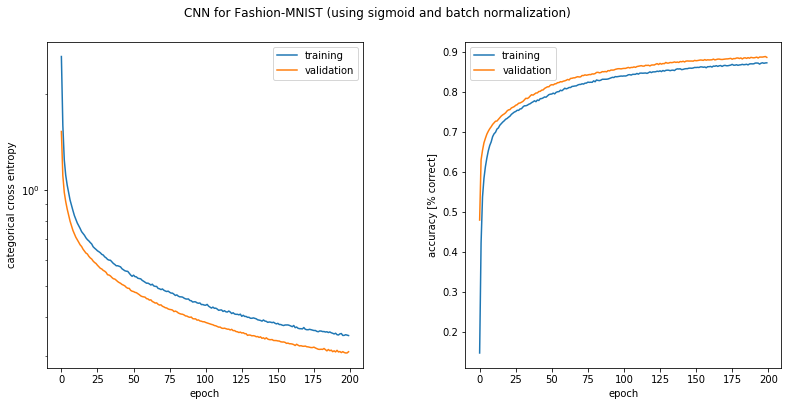

In [54]:
layers = [BatchNormalization( input_shape=input_shape),
          Conv2D(32, kernel_size=5, activation='sigmoid', input_shape=input_shape),
          MaxPooling2D(pool_size=(2,2)),
          Dropout(0.4),
          BatchNormalization(),
          Conv2D(64, kernel_size=5, activation='sigmoid'), 
          MaxPooling2D(pool_size=(2,2)),
          Dropout(0.4),
          Flatten(),
          BatchNormalization(),
          Dense(128, activation='sigmoid'),
          Dropout(0.4), BatchNormalization(),
          Dense(y_train[0].size, activation='softmax')]

fmnist_cnn_sb = create_model(opt=SGD(), loss='categorical_crossentropy', metrics=['accuracy'], layers=layers)
fmnist_cnn_sb_hist = fmnist_cnn_sb.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=200, verbose=0, validation_data=(x_fashion_test, y_fashion_test))
fig = plot_history(fmnist_cnn_sb_hist, 'CNN for Fashion-MNIST (using sigmoid and batch normalization)');
fig.set_size_inches([12,6]);

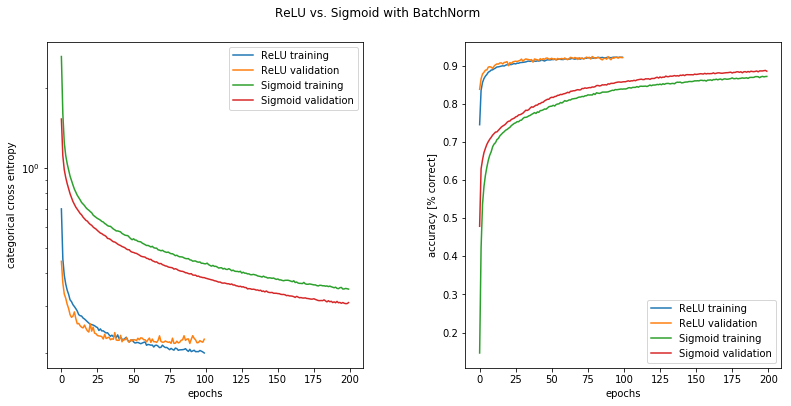

In [58]:
fig = comparison_plot(hist_fmnist_cnn, fmnist_cnn_sb_hist, 'ReLU', 'Sigmoid', 'ReLU vs. Sigmoid with BatchNorm')
fig.set_size_inches([12,6])

Answer to question 2: By adding BatchNormalization, we can see that the performance is much better. We have only trained our model for 100 epochs. Also, we can see that the model with ReLU activation seems to still perform better (faster and better convergence), but the sigmoid model 